In [1]:
# Imports
import os
import logging
import pandas as pd
logging.getLogger("wandb").setLevel(logging.ERROR)
logging.getLogger('tensorflow').setLevel(logging.ERROR)

os.environ['WANDB_SILENT'] = 'true'
os.environ['WANDB_CONSOLE'] = 'off'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment, py_environment, batched_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common
import matplotlib.pyplot as plt
import wandb

import sys
sys.path.insert(0, '..')
from environments.EnergyManagementEnv import EnergyManagementEnv
from utils.agentNetworks import ActorNetwork, CriticNetwork, CustomLayers
import utils.dataloader as DL

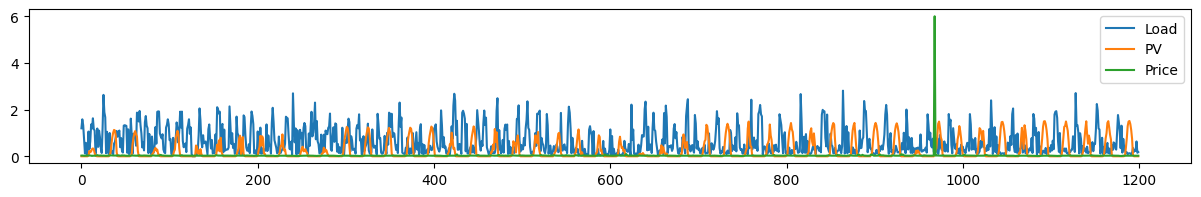

In [2]:
#Get data 
num_buildings = 1
building_data = {}

cwd = os.path.normpath(os.path.dirname(os.path.dirname(os.getcwd())))
df = pd.read_csv(cwd+'/data/3final_data/Final_Energy_dataset.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
df.fillna(0, inplace=True)

# Get the first date from the index

start_date = df.index.min()
train_end_date = start_date + pd.DateOffset(years=1)
eval_end_date = start_date + pd.DateOffset(years=2)
test_end_date = start_date + pd.DateOffset(years=3)

# Filter the DataFrame for eval and test periods
df_train = df[(df.index < train_end_date)]
df_eval = df[(df.index >= train_end_date) & (df.index < eval_end_date)]
df_test = df[(df.index >= eval_end_date) & (df.index < test_end_date)]

# Assuming num_buildings is defined as the number of buildings you have
for idx in range(num_buildings):
    # Extract columns for each building and each dataset
    cols = [f'load{idx+1}', f'pv{idx+1}', 'fuelmix', 'Price']
    data_train = df_train[cols].reset_index(drop=True)
    data_eval = df_eval[cols].reset_index(drop=True)
    data_test = df_test[cols].reset_index(drop=True)
    
    # Store data in the dictionary with the required structure
    building_data[f"building_{idx}"] = {
        'train': {'load': data_train[f'load{idx+1}'], 'pv': data_train[f'pv{idx+1}'], 'fuelmix': data_train['fuelmix'], 'price': data_train['Price']},
        'eval': {'load': data_eval[f'load{idx+1}'], 'pv': data_eval[f'pv{idx+1}'], 'fuelmix': data_eval['fuelmix'], 'price': data_eval['Price']},
        'test': {'load': data_test[f'load{idx+1}'], 'pv': data_test[f'pv{idx+1}'], 'fuelmix': data_test['fuelmix'], 'price': data_test['Price']}
    }

# Plotting
fig, ax = plt.subplots(figsize=(15,2)) 
building_data[f"building_{0}"]['train']['load'][:1200].plot(label='Load', ax=ax)
building_data[f"building_{0}"]['train']['pv'][:1200].plot(label='PV', ax=ax)
building_data[f"building_{0}"]['train']['price'][:1200].plot(label='Price', ax=ax)
plt.legend()
plt.show()

In [3]:
batch_size = 64

# Assuming Battery is your custom environment
# Define your environment creation function
def create_battery_env(load_data, pv_data, price_data):
    return EnergyManagementEnv(load_data=load_data, pv_data=pv_data, price_data=price_data)

# Training environment setup
py_envs_train = [create_battery_env(building_data[f"building_{0}"]['train']['load'], building_data[f"building_{0}"]['train']['pv'], building_data[f"building_{0}"]['train']['price']) for _ in range(batch_size)]
batched_env_train = batched_py_environment.BatchedPyEnvironment(envs=py_envs_train)
tf_env_train = tf_py_environment.TFPyEnvironment(batched_env_train)


# Print
print("Batch size: ", tf_env_train.batch_size)
num_states = tf_env_train.observation_spec().shape[0]
print("Size of State Space ->  {}".format(num_states)) #SoE, price, price forecast 1-6
num_actions = tf_env_train.action_spec().shape[0]
print("Size of Action Space ->  {}".format(num_actions))
upper_bound = tf_env_train.action_spec().maximum.item()
lower_bound = tf_env_train.action_spec().minimum.item()
print("Max Value of Action ->  {}".format(upper_bound))

Batch size:  64
Size of State Space ->  6
Size of Action Space ->  1
Max Value of Action ->  2.299999952316284


In [4]:
# Setup Environments

batch_size = 32

tf_env_train = tf_py_environment.TFPyEnvironment(batched_py_environment.BatchedPyEnvironment(
    [create_battery_env(
        building_data[f"building_{0}"]['train']['load'], 
        building_data[f"building_{0}"]['train']['pv'], 
        building_data[f"building_{0}"]['train']['price']) 
        for _ in range(batch_size)]
    )
)


tf_env_eval = tf_py_environment.TFPyEnvironment(batched_py_environment.BatchedPyEnvironment(
    [create_battery_env(
        building_data[f"building_{0}"]['eval']['load'], 
        building_data[f"building_{0}"]['eval']['pv'], 
        building_data[f"building_{0}"]['eval']['price']) 
        for _ in range(batch_size)]
    )
)

tf_env_test = tf_py_environment.TFPyEnvironment(batched_py_environment.BatchedPyEnvironment(
    [create_battery_env(
        building_data[f"building_{0}"]['test']['load'], 
        building_data[f"building_{0}"]['test']['pv'], 
        building_data[f"building_{0}"]['test']['price']) 
        for _ in range(batch_size)]
    )
)

print("Batch size: ", tf_env_train.batch_size)
print("State Space: {}, Action Space: {}".format(tf_env_train.observation_spec().shape[0], tf_env_train.action_spec().shape[0])) #SoE, price, price forecast 1-6
print("Upper bound: {}".format(round(tf_env_train.action_spec().maximum.item(), 3)))

Batch size:  32
State Space: 6, Action Space: 1
Upper bound: 2.3


In [5]:
# Setup Agent networks

global_step = tf.compat.v1.train.get_or_create_global_step()

"""actor_net = ActorNetwork(
    observation_spec=tf_env_train.observation_spec(),
    action_spec=tf_env_train.action_spec(),
    custom_layers=[CustomLayers.get_dense_layers(layers=1, units=4)],
    )

critic_net = CriticNetwork(
    observation_spec=tf_env_train.observation_spec(),
    action_spec=tf_env_train.action_spec(),
    custom_layers=[CustomLayers.get_dense_layers(layers=1, units=4)],
    )

target_actor_network = ActorNetwork(
    observation_spec=tf_env_train.observation_spec(),
    action_spec=tf_env_train.action_spec(),
    custom_layers=[CustomLayers.get_dense_layers(layers=1, units=4)],
    )

target_critic_network = CriticNetwork(
    observation_spec=tf_env_train.observation_spec(),
    action_spec=tf_env_train.action_spec(),
    custom_layers=[CustomLayers.get_dense_layers(layers=1, units=4)],
    )"""

from tf_agents.agents import ddpg

actor_net = ddpg.actor_network.ActorNetwork(
    input_tensor_spec=tf_env_train.observation_spec(),
    output_tensor_spec=tf_env_train.action_spec(), fc_layer_params=(400, 300),
    activation_fn=tf.keras.activations.relu)

critic_net = ddpg.critic_network.CriticNetwork(
    input_tensor_spec=(tf_env_train.observation_spec(), tf_env_train.action_spec()),
    joint_fc_layer_params=(400, 300),
    activation_fn=tf.keras.activations.relu)

target_actor_network = ddpg.actor_network.ActorNetwork(
    input_tensor_spec=tf_env_train.observation_spec(),
    output_tensor_spec=tf_env_train.action_spec(), fc_layer_params=(400, 300),
    activation_fn=tf.keras.activations.relu)

target_critic_network = ddpg.critic_network.CriticNetwork(
    input_tensor_spec=(tf_env_train.observation_spec(), tf_env_train.action_spec()),
    joint_fc_layer_params=(400, 300),
    activation_fn=tf.keras.activations.relu)

tf_agent = ddpg_agent.DdpgAgent(
    tf_env_train.time_step_spec(),
    tf_env_train.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4), #-2 bis -4
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3), #-1 bis -3
    ou_stddev=0.2, #0.3, # 0.2 , 0.3,
    ou_damping=0.15, #0.15, #0.15,
    target_actor_network=target_actor_network,
    target_critic_network=target_critic_network,
    target_update_tau=0.05, # 0.005, 0.01, 0.05,
    target_update_period=10, # 5, 20, 50
    dqda_clipping=1,
    td_errors_loss_fn= tf.compat.v1.losses.huber_loss, #tf.keras.losses.MeanSquaredError(),
    gamma=0.99, # 0.9, 0.99
    reward_scale_factor=10, # 1.0,
    train_step_counter=global_step,
)

tf_agent.initialize()
collect_policy = tf_agent.collect_policy

In [6]:
# Initialization for training

replay_buffer_capacity = 100000
initial_collect_steps = 1000
collect_steps_per_iteration = 2000
num_iterations = 2000

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=tf_env_train.batch_size,
    max_length=replay_buffer_capacity,
)

initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
    tf_env_train,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=initial_collect_steps,
)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    tf_env_train,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration,
)

wandb.login()
wandb.init(
    project="DDPG_battery_testing",
    job_type="train_eval_test",
    name="Horizon_3h_explore",
    config={
        "train_steps": num_iterations,
        "batch_size": batch_size,
        "actor_learning_rate": 1e-3,
        "critic_learning_rate": 1e-2}
)
artifact = wandb.Artifact(name='save', type="checkpoint")

eval_metrics = [tf_metrics.AverageReturnMetric(batch_size=batch_size)]
test_metrics = [tf_metrics.AverageReturnMetric(batch_size=batch_size)]

"""train_checkpointer = common.Checkpointer(
    ckpt_dir='checkpoints/ddpg/',
    max_to_keep=1,
    agent=tf_agent,
    policy=tf_agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)
train_checkpointer.initialize_or_restore()"""

global_step = tf.compat.v1.train.get_global_step()

# For better performance
initial_collect_driver.run = common.function(initial_collect_driver.run)
collect_driver.run = common.function(collect_driver.run)
tf_agent.train = common.function(tf_agent.train)

# Collect initial replay data
initial_collect_driver.run()
time_step = tf_env_train.reset()
policy_state = collect_policy.get_initial_state(tf_env_train.batch_size)

# pipeline which will feed data to the agent
dataset = replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)
iterator = iter(dataset)

UnknownError: Graph execution error:

Detected at node current_time_step/current_time_step_py_func defined at (most recent call last):
  File "C:\Users\rs1044\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main

  File "C:\Users\rs1044\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\rs1044\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever

  File "C:\Users\rs1044\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once

  File "C:\Users\rs1044\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\ipykernel\kernelbase.py", line 529, in dispatch_queue

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\ipykernel\kernelbase.py", line 518, in process_one

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\ipykernel\kernelbase.py", line 424, in dispatch_shell

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\ipykernel\kernelbase.py", line 766, in execute_request

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code

  File "C:\Users\rs1044\AppData\Local\Temp\ipykernel_22536\1273832387.py", line 62, in <module>

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\tf_agents\drivers\dynamic_step_driver.py", line 193, in run

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\tf_agents\utils\common.py", line 193, in with_check_resource_vars

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\tf_agents\drivers\dynamic_step_driver.py", line 203, in _run

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\tf_agents\environments\tf_environment.py", line 196, in current_time_step

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\tf_agents\environments\tf_py_environment.py", line 240, in _current_time_step

IndexingError: Too many indexers
Traceback (most recent call last):

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\tf_agents\environments\tf_py_environment.py", line 237, in _isolated_current_time_step_py
    return self._execute(_current_time_step_py)

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\tf_agents\environments\tf_py_environment.py", line 214, in _execute
    return fn(*args, **kwargs)

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\tf_agents\environments\tf_py_environment.py", line 233, in _current_time_step_py
    self._time_step = self._env.reset()

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\tf_agents\environments\py_environment.py", line 198, in reset
    self._current_time_step = self._reset()

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\tf_agents\environments\batched_py_environment.py", line 152, in _reset
    time_steps = self._execute(lambda env: env.reset(), self._envs)

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\tf_agents\environments\batched_py_environment.py", line 111, in _execute
    return self._pool.map(fn, iterable)

  File "C:\Users\rs1044\AppData\Local\Programs\Python\Python310\lib\multiprocessing\pool.py", line 364, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()

  File "C:\Users\rs1044\AppData\Local\Programs\Python\Python310\lib\multiprocessing\pool.py", line 771, in get
    raise self._value

  File "C:\Users\rs1044\AppData\Local\Programs\Python\Python310\lib\multiprocessing\pool.py", line 125, in worker
    result = (True, func(*args, **kwds))

  File "C:\Users\rs1044\AppData\Local\Programs\Python\Python310\lib\multiprocessing\pool.py", line 48, in mapstar
    return list(map(*args))

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\tf_agents\environments\batched_py_environment.py", line 152, in <lambda>
    time_steps = self._execute(lambda env: env.reset(), self._envs)

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\tf_agents\environments\py_environment.py", line 198, in reset
    self._current_time_step = self._reset()

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\src\notebooks\..\environments\EnergyManagementEnv.py", line 52, in _reset
    self._load_data.iloc[0,0],

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\pandas\core\indexing.py", line 1147, in __getitem__
    return self._getitem_tuple(key)

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\pandas\core\indexing.py", line 1652, in _getitem_tuple
    tup = self._validate_tuple_indexer(tup)

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\pandas\core\indexing.py", line 936, in _validate_tuple_indexer
    key = self._validate_key_length(key)

  File "c:\Users\rs1044\Documents\GitHub\Federated-Reinforcement-Learning-for-Battery-Charging\.venv\lib\site-packages\pandas\core\indexing.py", line 975, in _validate_key_length
    raise IndexingError("Too many indexers")

pandas.errors.IndexingError: Too many indexers


	 [[{{node current_time_step/current_time_step_py_func}}]] [Op:__inference_run_921]

In [ ]:
# Train and evaluate
print("Start training ...")
while global_step.numpy() < num_iterations:
    print(global_step.numpy(), "/ ", num_iterations)
    time_step, policy_state = collect_driver.run(
        time_step=time_step,
        policy_state=policy_state,
    )
    experience, _ = next(iterator)
    train_loss = tf_agent.train(experience)

    if global_step.numpy() % 2 == 0:
        metrics = {}    
        metrics["Loss"] = train_loss.loss
        wandb.log(metrics)

Start training ...
0 /  2000
1 /  2000
2 /  2000
3 /  2000
4 /  2000
5 /  2000
6 /  2000
7 /  2000
8 /  2000
9 /  2000
10 /  2000
11 /  2000
12 /  2000
13 /  2000
14 /  2000
15 /  2000
16 /  2000
17 /  2000
18 /  2000
19 /  2000
20 /  2000
21 /  2000
22 /  2000
23 /  2000
24 /  2000
25 /  2000
26 /  2000
27 /  2000
28 /  2000
29 /  2000
30 /  2000
31 /  2000
32 /  2000
33 /  2000
34 /  2000
35 /  2000
36 /  2000
37 /  2000
38 /  2000
39 /  2000
40 /  2000
41 /  2000
42 /  2000
43 /  2000
44 /  2000
45 /  2000
46 /  2000
47 /  2000
48 /  2000
49 /  2000
50 /  2000
51 /  2000
52 /  2000
53 /  2000
54 /  2000
55 /  2000
56 /  2000
57 /  2000
58 /  2000
59 /  2000
60 /  2000
61 /  2000
62 /  2000
63 /  2000
64 /  2000
65 /  2000
66 /  2000
67 /  2000
68 /  2000
69 /  2000
70 /  2000
71 /  2000
72 /  2000
73 /  2000
74 /  2000
75 /  2000
76 /  2000
77 /  2000
78 /  2000
79 /  2000
80 /  2000
81 /  2000
82 /  2000
83 /  2000
84 /  2000
85 /  2000
86 /  2000
87 /  2000
88 /  2000
89 /  2000
9

In [ ]:
print("Start testing ...")
metrics = metric_utils.eager_compute(
    test_metrics,
    tf_env_test,
    tf_agent.policy,
    num_episodes=batch_size)
logging = {}    
logging["AverageReturn"] = metrics['AverageReturn'].numpy()
wandb.log(logging)
#artifact.add_dir(local_path='checkpoints/ddpg/')
wandb.log_artifact(artifact)

wandb.finish() #46 min

Start testing ...
